<a href="https://colab.research.google.com/github/gabrielsob12/Audit-Supply-Register-Software/blob/main/Daily_Analisys_(stock_exchange).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**O objetivo deste case é preparar uma análise de dados da bolsa de valores que possa ser acessada com dados diários e auxilie na obtenção de insights**

Como dataframes temos ações de diversos ativos e segmentos do dia 26/01/2024. Após prosseguimento de análise de dados, avançamos para dados coletados de lib yfinance com raw data de 2023-01-01 ~ 2024-03-01

Iniciando com a limpeza e processamento de raw data (2024-01-26) enviado pelo cliente.

In [ ]:
import pandas as pd

daily_main = pd.read_excel("/content/daily_basis.xlsx", sheet_name="Principal")
daily_main = daily_main[['Ativo', 'Data', 'Último (R$)', 'Var. Dia (%)']].copy()
daily_main.head(10)

In [ ]:
daily_total_shares = pd.read_excel("/content/daily_basis.xlsx", sheet_name="Total_de_acoes")
daily_total_shares

Definindo novas colunas de análise com base no raw data fornecido:

*   var_pct: valor percentual diário de ações;
*   initial_value: valor inicial diário das ações;
*   qtd_share: quantidade de ações por ativos;
*   Código: eliminação da coluna com mesmos dados de ativos.





In [ ]:
daily_main = daily_main.rename(columns={'Último (R$)':'valor_final', 'Var. Dia (%)':'var_dia_percent'}).copy()
daily_main['var_pct'] = daily_main['var_dia_percent']/100
daily_main['initial_value'] = daily_main['valor_final'] / (daily_main['var_pct'] + 1)


## importação da aba Total_de_acoes para obter a qtd. total de ações de cada ativo
# comparando dados de "ativo" e "codigo" para identificar quantidades de ações
daily_main = daily_main.merge(daily_total_shares, left_on='Ativo', right_on='Código', how='left')
daily_main = daily_main.rename(columns={'Qtde. Teórica':'qtd_share'})
daily_main = daily_main.drop(columns={'Código'})
daily_main


Continuando o processamento de dados adicionando colunas:
*   Variação (R$) as var_total
*   Resultado variação as var_result



In [ ]:
#função var total
daily_main['var_total'] = (daily_main["valor_final"] - daily_main["initial_value"]) * daily_main["qtd_share"]

#função para resultado de variação
def var_result_func(valor):
    if valor > 0:
        return "Valor Subiu"
    elif valor < 0:
        return "Valor Diminuiu"
    else:
        return "Sem alteração"

#coluna var_result
daily_main['var_result'] = daily_main['var_total'].apply(var_result_func)
daily_main

Continuando o processamento de dados adicionando colunas:
*   Nome da empresa as comp_name
*   Segmento da empresa as comp_work
*   Idade da empresa as comp_age
*   Faixa de idade como comp_age_range

Finalizando assim o princial dataframe "daily_main"

In [ ]:
#importação de planilha com nomes
daily_names = pd.read_excel("/content/daily_basis.xlsx", sheet_name="Ticker")

#nome da companhia
daily_main = daily_main.merge(daily_names, left_on="Ativo", right_on="Ticker", how="left")
daily_main = daily_main.rename(columns={'Nome':'comp_name'})
daily_main = daily_main.drop(columns={'Ticker'})

#importação de planilha com ramo de atuação e idade
daily_comp = pd.read_excel("/content/daily_basis.xlsx", sheet_name="Informações Empresas CHAT GPT")

#colunas de segmento de trabalho e idade da empresa
daily_main = daily_main.merge(daily_comp, left_on='comp_name', right_on='Empresa', how='left')
daily_main = daily_main.drop(columns={'Empresa'})
daily_main = daily_main.rename(columns={'Idade da Empresa (Anos)':'comp_age', 'Ramo de Atuação': 'comp_work'})

#função para definir faixas de idade
def age_range(age):
    if age > 100:
        return "Centenária"
    elif age < 50:
        return "Menos de 50A"
    else:
        return "Entre 50A e 100A"

#criando a coluna range_age
daily_main['range_age'] = daily_main['comp_age'].apply(age_range)
daily_main

Criação de um dataframe auxiliar para cálculo de variações positivas e variações positivas por comp_work

In [ ]:
#criando dataframe auxiliar apenas com resultados de variação positiva
daily_main_increased = daily_main[daily_main['var_result'] == 'Valor Subiu']

#criando dataframe auxiliar com os resultados positivos por segmentos de trabalho
daily_comp_work = daily_main_increased.groupby('comp_work')['var_total'].sum().reset_index()
daily_comp_work

Avaliando os Ativos de diferentes segmentos, observa-se que o setor Energia/Petróleo possui larga vantagem sobre os outros.

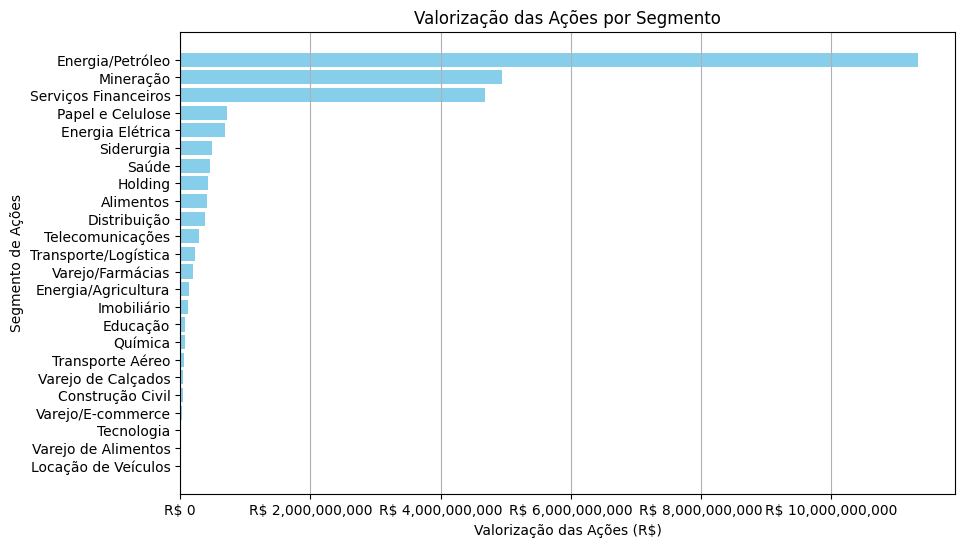

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Se o DataFrame já não estiver ordenado
daily_comp_work = daily_comp_work.sort_values(by='var_total', ascending=True)

# Plotando o gráfico de barras horizontais
plt.figure(figsize=(10, 6))  # Definindo o tamanho da figura
plt.barh(daily_comp_work['comp_work'], daily_comp_work['var_total'], color='skyblue')  # Criando o gráfico de barras horizontais
plt.xlabel('Valorização das Ações (R$)')  # Rótulo do eixo x
plt.ylabel('Segmento de Ações')  # Rótulo do eixo y
plt.title('Valorização das Ações por Segmento')  # Título do gráfico

# Formatando os valores no eixo x para reais
formatter = ticker.FuncFormatter(lambda x, pos: 'R$ {:,.0f}'.format(x))  # Definindo a formatação
plt.gca().xaxis.set_major_formatter(formatter)  # Aplicando a formatação ao eixo x

plt.grid(axis='x')  # Adicionando linhas de grade apenas no eixo x
plt.show()  # Exibindo o gráfico

Avaliando então os ativos que mais se valorizaram deste mesmo segmento do contexto (conforme dataframe do dia 26/01/2024 da bolsa de valores), temos:

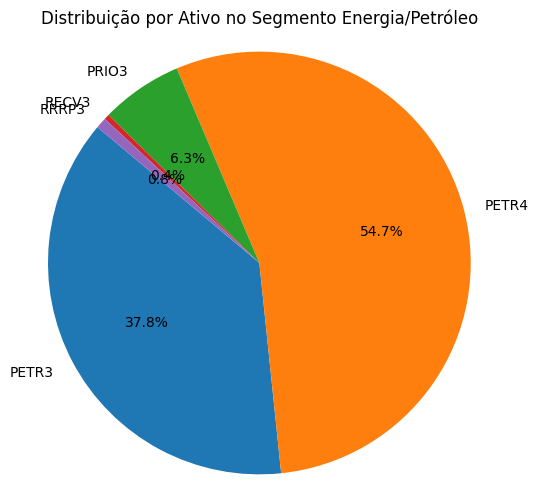

In [39]:
#filtrando os dados para ativos de comp_work = Energia/Petróleo
energia_petrolio_data = daily_main[(daily_main['comp_work'] == 'Energia/Petróleo') & (daily_main['var_result'] == 'Valor Subiu')]

#agrupando por ativo e somando os valores de var_total
var_total_por_ativo = energia_petrolio_data.groupby('Ativo')['var_total'].sum()

#plotando o gráfico de pizza
plt.figure(figsize=(6, 6))
plt.pie(var_total_por_ativo, labels=var_total_por_ativo.index, autopct='%1.1f%%', startangle=140)  #criando o gráfico de pizza
plt.title('Distribuição por Ativo no Segmento Energia/Petróleo')  #título do gráfico
plt.axis('equal')  #mantendo o gráfico de pizza circular
plt.show()  #exibindo o gráfico


Com o dataframe obtido neste case, é possível observar que as ações que mais se valorizaram, atingindo patamar acima de R$10mi, foram as ações do segmento de Energia/Petróleo, mais especificamente a PETR3 e PETR4 (ambas pertencente à estatal Petrobras SA).

Saindo do contexto diário e avaliando todo o período de 2023 até o final do primeiro bimestre de 2024, poderemos definir se o maior ativo (PETR4) continua apresentando tendência de valoração.

In [ ]:
import yfinance as yf

petr_data = yf.download('PETR4.SA', start='2023-01-01', end='2024-03-01')

Realizando avaliação dos preços de fechamento das ações PETR4 durante o período:

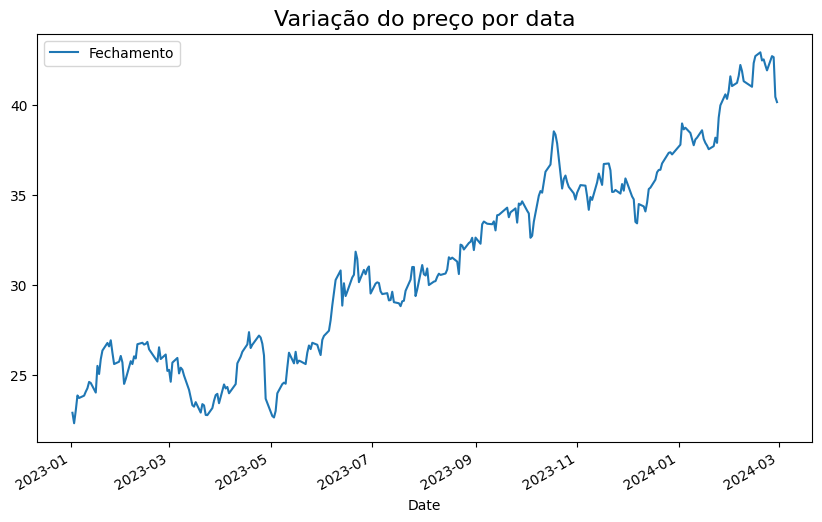

In [51]:
petr_data['Close'].plot(figsize=(10,6))
plt.title('Variação do preço por data', fontsize=16)
plt.legend(['Fechamento'])

Podemos perceber valorização assertiva e concreta dos preços de fechamento das ações no período avaliado (1 ano). Podendo ser uma ótima opção para carteiras de clientes mais conservadores e com baixa movimentação de ações.

Por fim, realizaremos a avaliação pelo gráfico de candlesticks, que retorna candles vermelhas (ação com valor de fechamento menor que o de abertura) e verdes (valor de fechamento maior que o de abertura) para o período de 2024.

In [ ]:
import matplotlib.dates as mdates

#preparação dos dados
df = petr_data.tail(32).copy()

#convertendo o índice em uma coluna de data
df['Date'] = df.index

#convertendo as datas para o formato numérico de matplotlib
df['Date'] = df['Date'].apply(mdates.date2num)
df

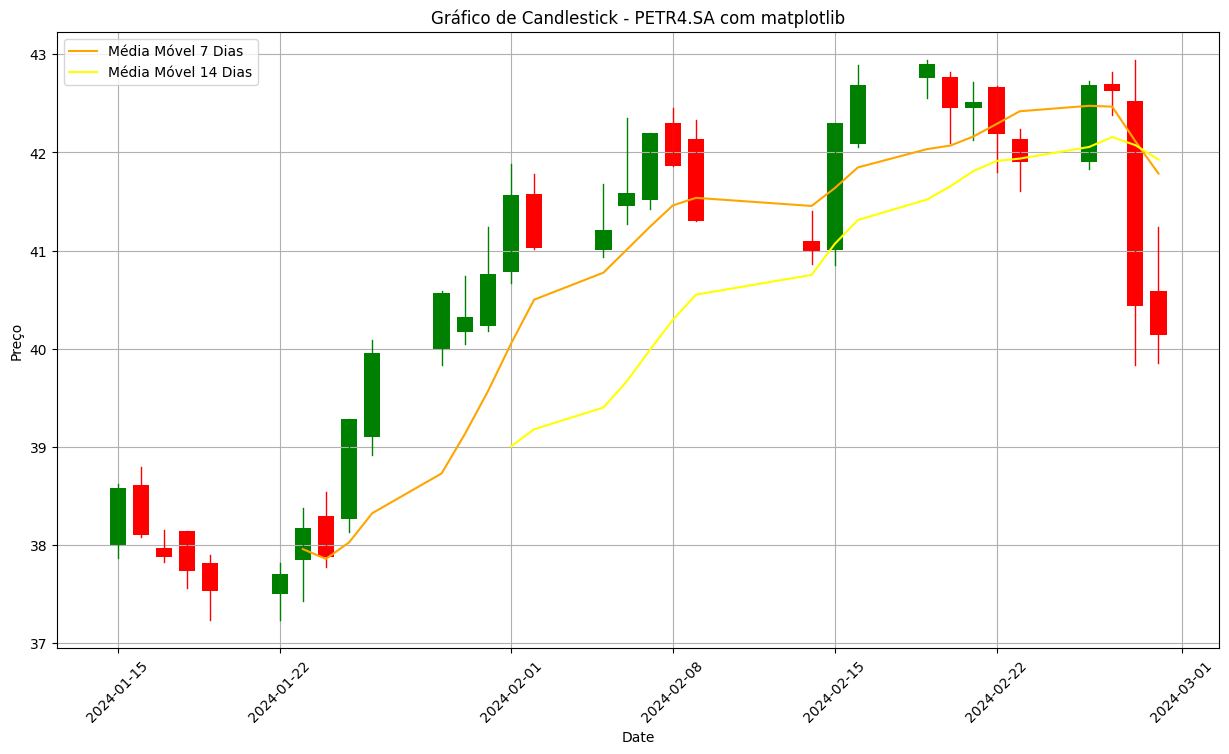

In [64]:
fig, ax = plt.subplots(figsize=(15, 8))

# Vamos definir a largura dos candles no gráfico
width = 0.7

for i in range(len(df)):
    # Determinando a cor do candle
    # Se o preço de Close for maior que o de Open, o candle é verde (a ação valorizou nesse dia).
    # Se for menor, o candle é vermelho (a ação desvalorizou).
    if df['Close'].iloc[i] > df['Open'].iloc[i]:
        color = 'green'
    else:
        color = 'red'

    # Desenhando a linha vertical do candle (mecha)
    # Essa linha mostra os preços máximo (topo da linha) e mínimo (base da linha) do dia.
    # Usamos `ax.plot` para desenhar uma linha vertical.
    # [df['Date'].iloc[i], df['Date'].iloc[i]] define o ponto x da linha (a Date), e [df['Mínimo'].iloc[i], df['Máximo'].iloc[i]] define a altura da linha.
    ax.plot([df['Date'].iloc[i], df['Date'].iloc[i]],
            [df['Low'].iloc[i], df['High'].iloc[i]],
            color=color,
            linewidth=1)

    ax.add_patch(plt.Rectangle((df['Date'].iloc[i] - width/2, min(df['Open'].iloc[i], df['Close'].iloc[i])),
                               width,
                               abs(df['Close'].iloc[i] - df['Open'].iloc[i]),
                               facecolor=color))

df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA14'] = df['Close'].rolling(window=14).mean()

# Plotando as médias móveis
ax.plot(df['Date'], df['MA7'], color='orange', label='Média Móvel 7 Dias')  # Média de 7 dias
ax.plot(df['Date'], df['MA14'], color='yellow', label='Média Móvel 14 Dias')  # Média de 14 dias
# Adicionando legendas para as médias móveis
ax.legend()

# Formatando o eixo x para mostrar as Dates
# Configuramos o formato da Date e a rotação para melhor legibilidade
ax.xaxis_date() #O método xaxis_date() é usado para dizer ao Matplotlib que as Dates estão sendo usadas no eixo x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Adicionando título e rótulos para os eixos x e y
plt.title("Gráfico de Candlestick - PETR4.SA com matplotlib")
plt.xlabel("Date")
plt.ylabel("Preço")

# Adicionando uma grade para facilitar a visualização dos valores
plt.grid(True)

# Exibindo o gráfico
plt.show()

Dessa maneira, é possível perceber que o insight obtido no gráfico de fechamento mantém-se, as ações da PETR4 valorizam-se a longo prazo, porém com algumas oscilações no período anual. Ideal para clientes de baixa movimentação de ativos e com carteiras mais conservadoras.